In [ ]:
import gym
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
!pip install gym[classic_control]
#pip install gym[box2d] #for lunarlander
!apt update
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gym-notebook-wrapper
import gnwrapper
!nvidia-smi
print(torch.cuda.is_available())

In [ ]:
class Agent(nn.Module):
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.model = PolicyNetwork(input_dim, output_dim, width)
        self.model.to(device)
        self.model.train()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0003)
        self.trajectory = []
        self.env = gym.make("CartPole-v1")        

    def forward(self, x):
        x = self.model(x)
        return x

    def self_play(self, max_timestep=1000000):
        game_score = 0
        state = self.env.reset() # env start
        for _ in range(max_timestep):
            output = self.forward(torch.from_numpy(state).float().to(device)) # inference
            prob_distribution = Categorical(output) 
            action = prob_distribution.sample() 
            state, r, done, _ = self.env.step(action.item())           
            self.trajectory.append((prob_distribution.log_prob(action), r)) 
            game_score += r 
            if done:
                break
        return game_score

    def update_weights(self):
        self.optimizer.zero_grad()
        G_t = 0
        for gradient_policy_a_s, r in self.trajectory[::-1]: 
            G_t = 0.99 * G_t + r
            loss = -1 * G_t * gradient_policy_a_s # -1 for gradient ascent
            loss.backward()
        self.optimizer.step()
        self.trajectory.clear()
        return

class PolicyNetwork(nn.Module):  
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_dim, width)
        self.layer2 = torch.nn.Linear(width, width) 
        self.layer3 = torch.nn.Linear(width, output_dim) 

    def forward(self, x):
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        x = self.layer3(x)
        x = torch.nn.functional.softmax(x, dim=0)
        return x

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
score_arr = []
env = gym.make("CartPole-v1") 
agent = Agent(env.observation_space.shape[0], env.action_space.n, 128) 
print(agent)
env.close()

#Self play, weight update
episode_nums = 1000
for i in range(episode_nums):
    game_score = agent.self_play() 
    score_arr.append(game_score)    
    agent.update_weights()       
    if i%50==0 : print('episode', i)   
torch.save(agent.state_dict(), 'weights.pt') 
agent.env.close()

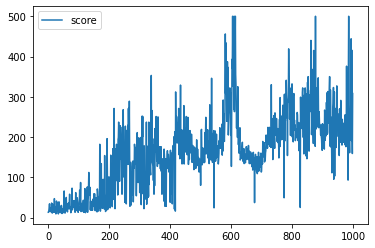

In [ ]:
# Score
plt.plot(score_arr, label ='score')
plt.legend(loc='upper left')

In [ ]:
# play video
agent.load_state_dict(torch.load("weights.pt"))
env = gnwrapper.LoopAnimation(gym.make('CartPole-v1'))
state = env.reset()
for _ in range(200):
    with torch.no_grad():
        output = agent.forward(torch.from_numpy(state).float().to(device)) # inference
        prob_distribution = Categorical(output)
        action = prob_distribution.sample() 
    env.render()
    state, rew, done, _ = env.step(action.item())
    if done:
        state = env.reset()
env.display()